In [114]:
import pickle
import sys
import csv
sys.path.append(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project')
from execute_remote_scripts import *
from Processing_Data.downsampling import *
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
%load_ext autoreload
%autoreload 2
from Server_Scripts.remote_processing_csv import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Probability Density Functions of the Data

In [90]:
base_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_Files'
files = os.listdir(base_path)
RE_autom = list(pd.read_csv(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\automatic_RE_numbers.csv', header=None)[0])
RE_valid = list(pd.read_csv(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\validated_RE_numbers.csv', header=None)[0])
NO_RE_probably = [key for key in dataframes.keys() if key not in RE_autom and key not in RE_valid]

In [95]:
dataframes = {}
for file in files:
    dataframes[int(file.split('.')[0].split('no')[1])] = pd.read_csv(os.path.join(base_path, file))

In [130]:
features = list(dataframes[NO_RE_probably[0]].keys()) #to_numpy()
features.pop(features.index('time'))
features

['SSXcore', 'IP', 'DAO_EDG7', 'WMHD', 'RNT']

### Plotting PDFs for Re and non Re

In [135]:
# For runaway electrons
features_extrema = {}

for feature in features:
    temp = []
    for RE_key in RE_valid:
        temp.append(dataframes[RE_key][feature].to_numpy())
    features_extrema[feature] = (np.min(temp), np.max(temp))

features_densities = {}
for feature in features:
    temp = []
    min, max = features_extrema[feature]
    for RE_key in RE_valid:
        kde = gaussian_kde(dataframes[RE_key][feature].to_numpy())
        x = np.linspace(min, max, 1000)
        y = kde(x)
        temp.append(y)
    features_densities[feature] = np.mean(np.array(temp), axis=0)

ValueError: array must not contain infs or NaNs

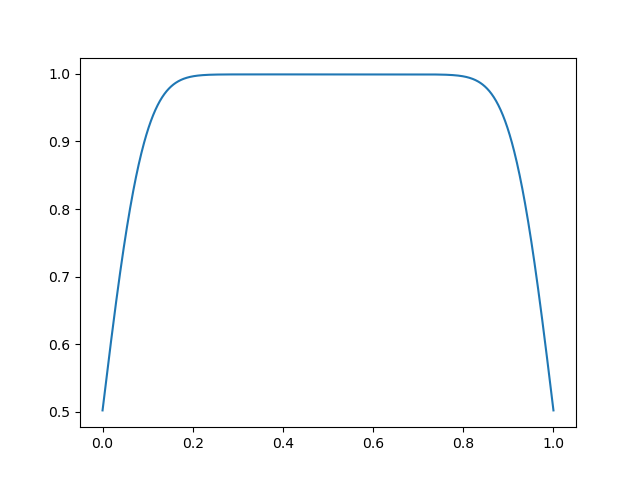

In [128]:
plt.close()
x = np.linspace(0, 1, 1000)
plt.plot(x, gaussian_kde(x)(x))

In [127]:
min(x)

0.0

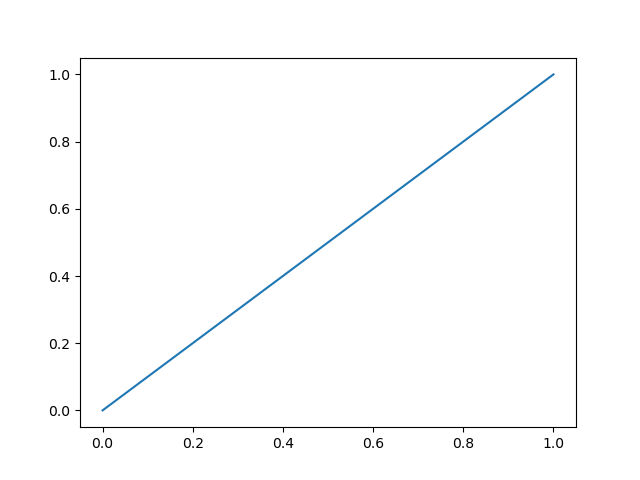

In [123]:
plt.close()
plt.plot(x, x)

## Comparing original data with downsampled data

In [5]:
file_original = load_pickle(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\20_random_JET_data.pkl')
original_data = file_original['JETno85000']
downsampled_data = pd.read_csv(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_Files\JETno85000.csv') # These data are downsampled while downloaded

In [11]:
SSX = shot['SSXcore']
t_b = shot['Ramp_up'][0]
t_e = shot['Ramp_down'][1]
original_time = SSX['time'][(SSX['time'] >= t_b) & (SSX['time'] <= t_e)]
original_data = SSX['signal'][(SSX['time'] >= t_b) & (SSX['time'] <= t_e)]
print(t_b, t_e)

40.917400001490115 59.467300001490116


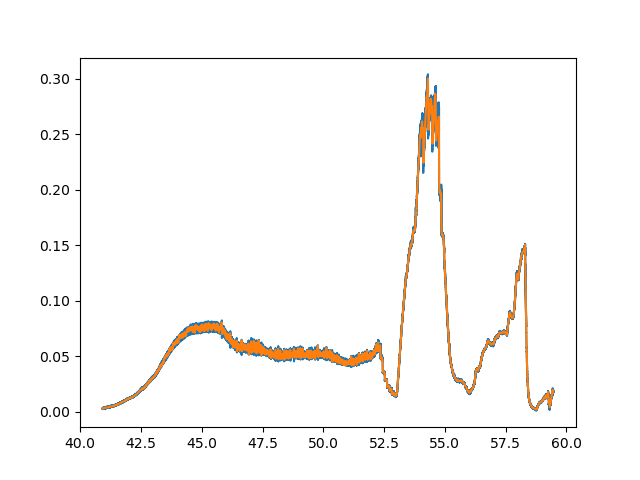

In [12]:
plt.close()
plt.plot(original_time, original_data)
plt.plot(downsampled_data['time'], downsampled_data['SSXcore'], '-')
plt.show()

In [4]:
merged_df = downsample_and_merge(shot)
plt.close()
plt.plot(merged_df['time'], merged_df['IP'])
plt.plot(shot['IP']['time'], shot['IP']['signal'], '--')